In [1]:
import numpy as np
import scipy.sparse as sps
import porepy as pp
import math
import sys
import matplotlib.pyplot as plt

/home/dell/anaconda3/lib/python3.8/site-packages/porepy/viz/plot_grid.py:241: UserWarning: Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.
  ax.set_zlim3d(z)


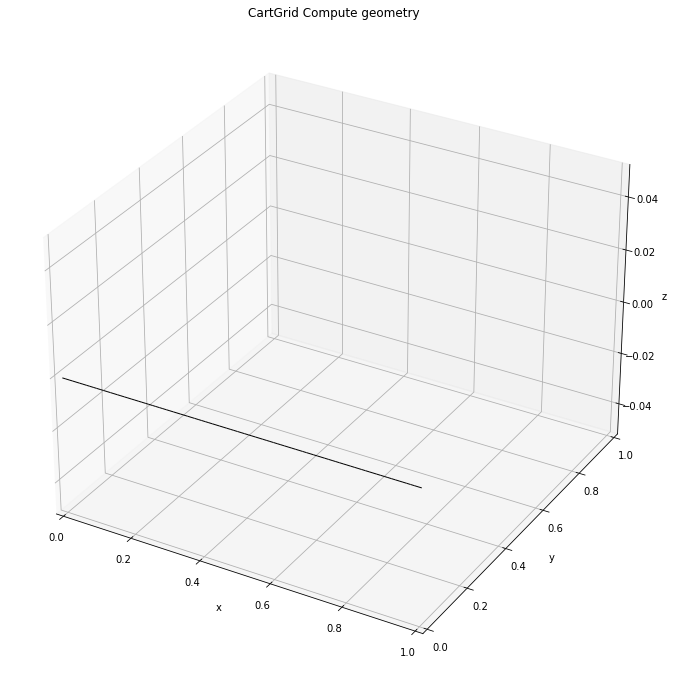

In [2]:
#Nx = Ny = 20
Nx=100
h=1/Nx
#phys_dims = [1,1]
phys_dims=[1]
#g = pp.CartGrid([Nx, Ny], phys_dims)
g=pp.CartGrid([Nx],phys_dims)
g.compute_geometry()
pp.plot_grid(g, figsize=(15, 12))

In [3]:
def add_transport_data_2_reagent(g):
    tol=1e-4
    
    b_faces_reagent_1 = g.tags["domain_boundary_faces"].nonzero()[0]
    bc_val_reagent_1 = np.zeros(g.num_faces)
    
    b_faces_reagent_2 = g.tags["domain_boundary_faces"].nonzero()[0]
    bc_val_reagent_2  = np.zeros(g.num_faces)
    
    unity = np.ones(g.num_cells)
    empty = np.empty(0)
    if b_faces_reagent_1.size != 0:
        
        b_face_centers_reagent_1 = g.face_centers[:, b_faces_reagent_1]
        b_inflow_reagent_1 = b_face_centers_reagent_1[0, :] < tol
        b_outflow_reagent_1 = b_face_centers_reagent_1[0, :] > 1-tol

        labels_reagent_1 = np.array(["neu"] * b_faces_reagent_1.size)
        labels_reagent_1[np.logical_or(b_inflow_reagent_1, b_outflow_reagent_1)] = "dir"
        bc_reagent_1 = pp.BoundaryCondition(g, b_faces_reagent_1, labels_reagent_1)

        bc_val_reagent_1[b_faces_reagent_1[b_inflow_reagent_1]] = 0
        
        b_face_centers_reagent_2 = g.face_centers[:, b_faces_reagent_2]
        b_inflow_reagent_2 = b_face_centers_reagent_2[0, :] < tol
        b_outflow_reagent_2 = b_face_centers_reagent_2[0, :] > 1-tol

        labels_reagent_2 = np.array(["neu"] * b_faces_reagent_2.size)
        labels_reagent_2[np.logical_or(b_inflow_reagent_2, b_outflow_reagent_2)] = "dir"
        bc_reagent_2 = pp.BoundaryCondition(g, b_faces_reagent_2, labels_reagent_2)

        bc_val_reagent_2[b_faces_reagent_2[b_inflow_reagent_2]] = 0


    else:
        bc_reagent_1 = pp.BoundaryCondition(g) #, empty, empty)
        bc_reagent_2 = pp.BoundaryCondition(g) #, empty, empty)
    
    porosity=unity
    aperture=1
    
    specified_parameters = {
            "bc_reagent_1": bc_reagent_1,
            "bc_values_reagent_1": bc_val_reagent_1,
            "bc_reagent_2": bc_reagent_2,
            "bc_values_reagent_2": bc_val_reagent_2, 
            "Nt": 10000,
            "mass_weight": porosity * aperture,
            "darcy_flux":np.ones(Nx+1),
            "t_max": 345600,
            "method": "Implicit",
            }
    d=pp.initialize_data(g, {},'transport', specified_parameters)
    
    return g,d

In [4]:
def add_transport_data(g):
    tol=1e-4
    
    b_faces = g.tags["domain_boundary_faces"].nonzero()[0]
    bc_val = np.zeros(g.num_faces)
    
    unity = np.ones(g.num_cells)
    empty = np.empty(0)
    if b_faces.size != 0:
        b_face_centers = g.face_centers[:, b_faces]
        b_inflow = b_face_centers[0, :] < tol
        b_outflow = b_face_centers[0, :] > 1-tol

        labels = np.array(["neu"] * b_faces.size)
        labels[np.logical_or(b_inflow, b_outflow)] = "dir"
        bc = pp.BoundaryCondition(g, b_faces, labels)

        bc_val[b_faces[b_inflow]] = 0

    else:
        bc = pp.BoundaryCondition(g) #, empty, empty)
    
    porosity=unity
    aperture=1
    
    specified_parameters = {
            "bc": bc,
            "bc_values": bc_val,
            "Nt": 10000,
            "mass_weight": porosity * aperture,
            "darcy_flux":np.ones(Nx+1),
            "t_max": 345600,
            "method": "Implicit",
            }
    d=pp.initialize_default_data(
        , {},'transport', specified_parameters)
    
    return g,d

SyntaxError: invalid syntax (<ipython-input-4-7b874e9ae852>, line 36)

In [5]:
def add_reaction_data(g):
    
    specified_parameters = {
             "temperature":423,
             "A":1.9e-2,
             "rate_const":0.004466,
             "E":4700,
             "R":8.314,
             "K_eq":10e9,
             "ph":3.5,
            }
    d=pp.initialize_data(g, {},'reagent', specified_parameters)
    
    return d

In [66]:
def reaction_rate(d):
    A=d[pp.PARAMETERS]["reagent"]["A"]
    rate_const=d[pp.PARAMETERS]["reagent"]["rate_const"]
    E=d[pp.PARAMETERS]["reagent"]["E"]
    R=d[pp.PARAMETERS]["reagent"]["R"]
    temperature=d[pp.PARAMETERS]["reagent"]["temperature"]
    
    const_r_d=A*rate_const*math.exp(-E/(R*temperature))
    #react_const=area*rate_const*(std::exp(-E/(R*temperature)));
    return const_r_d
    

In [67]:
g,d=add_transport_data_2_reagent(g)
print(d[pp.PARAMETERS]["transport"]["t_max"])
d1=add_reaction_data(g)
const_r=reaction_rate(d1)
ph=d1[pp.PARAMETERS]["reagent"]["ph"]
phi=d[pp.PARAMETERS]["transport"]["mass_weight"]
K_eq=d1[pp.PARAMETERS]["reagent"]["K_eq"]
kw_t="transport"

345600


In [68]:
def update_react(past_sol):
    p=np.power(past_sol,2)/(K_eq*math.pow(10,-2*ph))
    for i in range(Nx):
        rhs[i]=h*phi[i]*max(const_r*(1.0-p[i]),0.0)
    return rhs
    print(h)

In [69]:
node_discretization = pp.Upwind(kw_t)
source_discretization = pp.ScalarSource(kw_t)
mass_discretization = pp.MassMatrix(kw_t)

In [70]:
node_discretization.discretize(g,d)
source_discretization.discretize(g,d)
mass_discretization.discretize(g,d)

KeyError: 'bc'

In [56]:
A_upwind,b_upwind=node_discretization.assemble_matrix_rhs(g,d)
_,b_source=source_discretization.assemble_matrix_rhs(g,d)
A_mass,b_mass=mass_discretization.assemble_matrix_rhs(g,d)

In [57]:
dt=d[pp.PARAMETERS]["transport"]["t_max"]/d[pp.PARAMETERS]["transport"]["Nt"]
print(dt)

if d[pp.PARAMETERS]["transport"]["method"]=="Explicit":
    lhs1 =1/dt*A_mass
    lhs2 =1/dt*A_mass
else:
    lhs1=1/dt*A_mass+A_upwind
    lhs2=1/dt*A_mass    
rhs=b_upwind+b_source+b_mass
IEsolver1 = sps.linalg.factorized(lhs1)
IEsolver2 = sps.linalg.factorized(lhs2)

34.56


In [58]:
save_every = 1
n_steps = d[pp.PARAMETERS]["transport"]["Nt"] 
# Initial condition
Ca = np.zeros(Nx)
#tracer[np.logical_and(g.cell_centers[0,:]<0.3, g.cell_centers[0,:]>0.2)]=1.0
CaSiO3=16.7504*np.ones(Nx)



# Exporter
exporter = pp.Exporter(g, file_name="2_reagents",folder_name="solution")

In [59]:
for i in range(n_steps):
    
    rhs_react=update_react(Ca)
    if np.isclose(i % save_every, 0):
        # Export existing solution (final export is taken care of below)
        exporter.write_vtu({"Ca":Ca, "CaSiO3":CaSiO3}, time_step=int(i // save_every))
        #exporter.write_vtu({"CaSiO3":CaSiO3},time_step=int(i//save_every))
    if d[pp.PARAMETERS]["transport"]["method"]=="Explicit":
        Ca = IEsolver1((1/dt*A_mass-A_upwind)*Ca+rhs+rhs_react*CaSiO3)
        CaSiO3=IEsolver2((1/dt*A_mass)*CaSiO3)
    else:
        Ca = IEsolver1((1/dt*A_mass)*Ca + rhs+rhs_react*CaSiO3)
        CaSiO3=IEsolver2((1/dt*A_mass)*CaSiO3-rhs_react*CaSiO3)
    
#print(1/dt*A_mass-A_upwind)

exporter.write_vtu({"Ca":Ca, "CaSiO3":CaSiO3}, time_step=(n_steps // save_every))

                         
time_steps = np.arange(
    0, d[pp.PARAMETERS]["transport"]["t_max"] + dt, save_every * dt
)
exporter.write_pvd(time_steps)